Nous commençons par charger les librairies requises.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# *Supplément - Fonction d'affichage*
*Cette fonction sera utilisée plus tard pour les visualisations. Il n'est pas nécessaire de la parcourir. Il vous suffit d'exécuter le code.*

In [2]:
def plot_data_scatter(x1, y1, x2, y2, feature_list):
    # Affichez les résultats
    n_row_plot = int((len(feature_list) + 1) / 2) # 2 plots per row
    n_col_plot = 2
    fig, ax = plt.subplots(n_row_plot, n_col_plot, figsize=(12, 12))
    
    i = 0  # index des colonnes du tracé
    j = 0  # index des lignes du tracé
        
    for count in range(len(feature_list)):
        # affichage des données
        ax[j, i].scatter(x1[:, count], y1, s=20, edgecolor="black", c="darkorange", label="data")
        # affichage des prédictions
        ax[j, i].scatter(x2[:, count], y2, s=30, marker="X", c="royalblue", label="prediction")
        ax[j, i].set(title=feature_list[count])
        ax[j, i].set(ylabel='UNITS')
        i = min(i + 1,len(feature_list)) % n_col_plot
        if i == 0: j += 1

    plt.show()

# Bloc 1: chargement des données
Les données importées consistent aux données `'salesCerealsOriginal.csv'` que nous avons utilisées dans le passé.

In [3]:
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/data/salesCerealsOriginal.csv'
salesCereals = pd.read_csv(url)
salesCereals.head(5)

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,DESCRIPTION,CATEGORY,SUB_CATEGORY
0,2009-01-14,367,1111085319,14,13,13,26.32,1.88,1.88,0,0,0,PL HONEY NUT TOASTD OATS,COLD CEREAL,ALL FAMILY CEREAL
1,2009-01-14,367,1111085350,35,27,25,69.30,1.98,1.98,0,0,0,PL BT SZ FRSTD SHRD WHT,COLD CEREAL,ALL FAMILY CEREAL
2,2009-01-14,367,1600027527,12,10,10,38.28,3.19,3.19,0,0,0,GM HONEY NUT CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL
3,2009-01-14,367,1600027528,31,26,19,142.29,4.59,4.59,0,0,0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL
4,2009-01-14,367,1600027564,56,48,42,152.32,2.72,3.07,1,0,0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL


*UPC* signifie *Unique Product Code*, qui peut être compris comme un *SKU* (*Stock-Keeping Unit*) dans ce cas. Le code suivant nous aide à identifier les UPC pour lesquels nous voulons faire des prévisions et leur nombre d'observations correspondants. Nous pouvons voir que le nombre d'observations pour chaque UPC est similaire et qu'il n'y a pas d'UPC avec très peu d'observations. Ceci est important car l'entraînement d'un modèle sur un petit ensemble de données peut limiter sa généralisation.

In [4]:
salesCereals.groupby('UPC').count()

,WEEK_END_DATE,STORE_NUM,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,DESCRIPTION,CATEGORY,SUB_CATEGORY
UPC,,,,,,,,,,,,,,
1111085319,156,156,156,156,156,156,156,156,156,156,156,156,156,156
1111085350,156,156,156,156,156,156,156,156,156,156,156,156,156,156
1600027527,156,156,156,156,156,156,156,156,156,156,156,156,156,156
1600027528,156,156,156,156,156,156,156,156,156,156,156,156,156,156
1600027564,155,155,155,155,155,155,155,155,155,155,155,155,155,155
3000006340,133,133,133,133,133,133,133,133,133,133,133,133,133,133
3800031829,155,155,155,155,155,155,155,155,155,155,155,155,155,155


# Bloc 2: extraction des caractéristiques
À ces données, nous allons ajouter de nouvelles caractéristiques, soit:
 - `'SUMPRICE'`: le prix total des UPC dans une semaine particulière,
 - `'COUNTPRICE'`: le nombre d'UPC dans une semaine particulière,
 - `'AVGPRICE'`: le prix moyen des UPC dans une semaine particulière,
 - `'RELPRICE'`: le ratio entre le prix d'un UPC et le prix moyen, et
 - `'PRICE_p2'`: le prix au carré.

Nous commençons par calculer `'SUMPRICE'`, `'COUNTPRICE'` et `'AVGPRICE'`.

In [5]:
temp = salesCereals.groupby('WEEK_END_DATE').PRICE.agg(['sum', 'count', 'mean'])  # calcul
temp = temp.rename(  # renommage des colonnes
    columns={'sum': 'SUMPRICE', 'count': 'COUNTPRICE', 'mean': 'AVGPRICE'})
temp.head()

,SUMPRICE,COUNTPRICE,AVGPRICE
WEEK_END_DATE,,,
2009-01-14,19.54,7,2.791429
2009-01-21,20.07,7,2.867143
2009-01-28,20.73,7,2.961429
2009-02-04,20.72,7,2.960000
2009-02-11,15.96,7,2.280000


Par la suite, nous ajoutons ces colonnes dans le DataFrame `salesCereals` avec la méthode `join`.

In [6]:
salesCereals = salesCereals.set_index('WEEK_END_DATE').join(temp).reset_index()  # ajout colonnes
salesCereals = salesCereals.sort_values(['WEEK_END_DATE', 'UPC'])  # tri
salesCereals.head(10)

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,DESCRIPTION,CATEGORY,SUB_CATEGORY,SUMPRICE,COUNTPRICE,AVGPRICE
0,2009-01-14,367,1111085319,14,13,13,26.32,1.88,1.88,0,0,0,PL HONEY NUT TOASTD OATS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429
1,2009-01-14,367,1111085350,35,27,25,69.30,1.98,1.98,0,0,0,PL BT SZ FRSTD SHRD WHT,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429
2,2009-01-14,367,1600027527,12,10,10,38.28,3.19,3.19,0,0,0,GM HONEY NUT CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429
3,2009-01-14,367,1600027528,31,26,19,142.29,4.59,4.59,0,0,0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429
4,2009-01-14,367,1600027564,56,48,42,152.32,2.72,3.07,1,0,0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429
5,2009-01-14,367,3000006340,19,17,17,38.76,2.04,2.74,0,0,1,QKER LIFE ORIGINAL,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429
6,2009-01-14,367,3800031829,14,11,3,43.96,3.14,3.14,0,0,0,KELL BITE SIZE MINI WHEAT,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429
7,2009-01-21,367,1111085319,12,12,12,22.68,1.89,1.89,0,0,0,PL HONEY NUT TOASTD OATS,COLD CEREAL,ALL FAMILY CEREAL,20.07,7,2.867143
8,2009-01-21,367,1111085350,33,25,25,66.00,2.00,2.00,0,0,0,PL BT SZ FRSTD SHRD WHT,COLD CEREAL,ALL FAMILY CEREAL,20.07,7,2.867143
9,2009-01-21,367,1600027527,7,7,7,22.33,3.19,3.19,0,0,0,GM HONEY NUT CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,20.07,7,2.867143


Nous ajoutons maintenant les colonnes `'RELPRICE'` et `'PRICE_p2'`.

In [7]:
salesCereals['RELPRICE'] = salesCereals['PRICE'] / salesCereals['AVGPRICE']
salesCereals['PRICE_p2'] = salesCereals['PRICE'] ** 2
salesCereals.head()

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,DESCRIPTION,CATEGORY,SUB_CATEGORY,SUMPRICE,COUNTPRICE,AVGPRICE,RELPRICE,PRICE_p2
0,2009-01-14,367,1111085319,14,13,13,26.32,1.88,1.88,0,0,0,PL HONEY NUT TOASTD OATS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.673490,3.5344
1,2009-01-14,367,1111085350,35,27,25,69.30,1.98,1.98,0,0,0,PL BT SZ FRSTD SHRD WHT,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.709314,3.9204
2,2009-01-14,367,1600027527,12,10,10,38.28,3.19,3.19,0,0,0,GM HONEY NUT CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,1.142784,10.1761
3,2009-01-14,367,1600027528,31,26,19,142.29,4.59,4.59,0,0,0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,1.644319,21.0681
4,2009-01-14,367,1600027564,56,48,42,152.32,2.72,3.07,1,0,0,GM CHEERIOS,COLD CEREAL,ALL FAMILY CEREAL,19.54,7,2.791429,0.974411,7.3984


On sauvegarde ce nouveau jeu de données pour plus tard.

In [8]:
salesCereals.to_csv('salesCereals.csv', index=False)

Finalement, nous organisons les données par UPC. Le modèle présenté ici ne fonctionne que sur un sous-ensemble prédéterminé de variables dans les données. Vous pouvez ajouter ou supprimer ces variables prédictives en fonction de votre jugement.

In [9]:
feature_list = ['PRICE', 'PRICE_p2', 'FEATURE', 'DISPLAY', 'TPR_ONLY', 'RELPRICE']

productList = salesCereals['UPC'].unique()
print("productList:", productList)

# On va stocker les données dans des dictionnaires où la clé correspond au UPC
X, X_train, X_test = {}, {}, {}
y, y_train, y_test, y_pred = {}, {}, {}, {}  # y_pred stocke les prédictions pour y_test

for upc in productList:
    X[upc] = salesCereals.loc[salesCereals['UPC'] == upc, feature_list].values  # pour avoir des numpy array partout
    y[upc] = salesCereals.loc[salesCereals['UPC'] == upc, 'UNITS'].values  # pour avoir des numpy array partout
    # Séparation en données d'entrainement et de test
    X_train[upc], X_test[upc], y_train[upc], y_test[upc] = train_test_split(
        X[upc], y[upc], test_size=0.25, random_state=0)

productList: [1111085319 1111085350 1600027527 1600027528 1600027564 3000006340
 3800031829]


# Bloc 3: modèles (entraînement et évaluation)
Dans cette section, nous entraînons et évaluons trois types différents de modèles, à savoir la régression linéaire, l'arbre de régression et la forêt aléatoire. À chaque reprise, nous itérons **sur chaque UPC** de la liste de produits. La première ligne de la boucle consiste à entraîner le modèle et les lignes suivantes calculent les différentes mesures de performance.

## Régression linéaire
Nous organisons le résultat de la régression linéaire (et des autres modèles) par UPC (lignes) et mesures de performance (colonnes). À chaque itération, nous mettons les mesures calculées dans la ligne correspondante.

In [10]:
regr = {}  # nous stockons les différents modèles dans un dictionnaire
regrSummary = pd.DataFrame(columns=['trainRMSE', 'testRMSE','testMAE','testMAPE'], 
                           index=productList)

for upc in productList:
    regr[upc] = LinearRegression().fit(X_train[upc], y_train[upc])  # crée et entraîne le modèle
    y_pred_train = regr[upc].predict(X_train[upc])  # calcule les prédictions pour y_train
    trainRMSE = np.sqrt(mean_squared_error(y_train[upc], y_pred_train))  # calule le RMSE en faisant la racine de MSE

    y_pred[upc] = regr[upc].predict(X_test[upc])

    testRMSE = np.sqrt(mean_squared_error(y_test[upc], y_pred[upc]))
    testMAE = mean_absolute_error(y_test[upc], y_pred[upc])
    testMAPE = np.mean(np.abs((y_test[upc] - y_pred[upc]) / y_test[upc]))
    regrSummary.loc[upc] = [trainRMSE, testRMSE, testMAE, testMAPE]  # met les résultats sur la ligne upc

print('**Régression linéaire**')
with pd.option_context('display.precision', 3):  # permet de changer l'affichage des décimales
    display(regrSummary)
print(f"Moyenne des RMSE d'entraînement: {regrSummary['trainRMSE'].mean():.2f}")
print(f"Moyenne des RMSE d'évaluation: {regrSummary['testRMSE'].mean():.2f}")
print(f"Moyenne des MAE d'évaluation: {regrSummary['testMAE'].mean():.2f}")
print(f"Moyenne des MAPE d'évaluation: {regrSummary['testMAPE'].mean():.2f}")

**Régression linéaire**


,trainRMSE,testRMSE,testMAE,testMAPE
1111085319,7.713,8.233,6.569,0.839
1111085350,7.306,7.696,6.135,0.749
1600027527,15.073,23.52,13.547,0.548
1600027528,9.073,14.065,8.088,0.252
1600027564,8.77,6.797,5.24,0.277
3000006340,4.256,3.874,2.886,0.72
3800031829,7.65,8.519,6.575,0.379


Moyenne des RMSE d'entraînement: 8.55
Moyenne des RMSE d'évaluation: 10.39
Moyenne des MAE d'évaluation: 7.01
Moyenne des MAPE d'évaluation: 0.54


Ici, nous visualisons les observations de test (en orange) et les prédictions sur les données de test (en bleu) à l'aide de la fonction d'affichage précédemment définie.

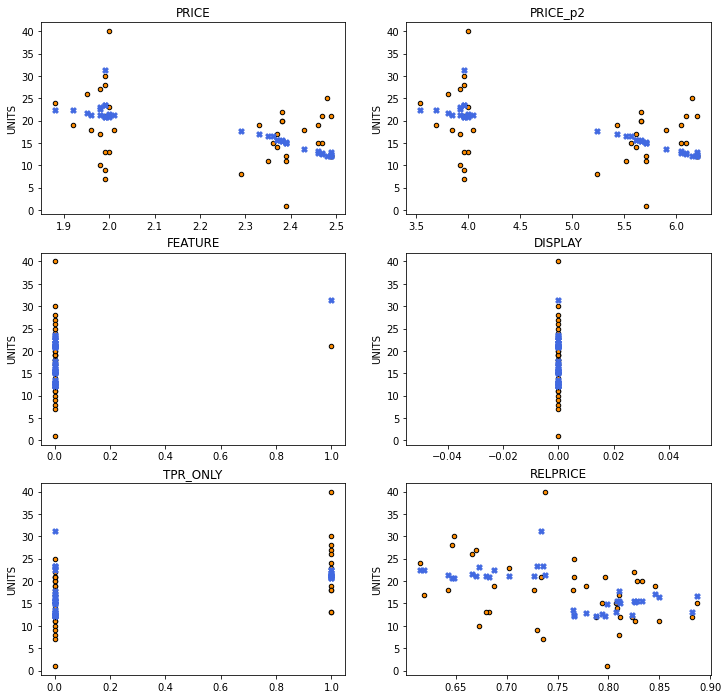

In [11]:
# Montrer les résultats de prédiction pour un produit (UPC)
upc = productList[1]  # sélection d'un UPC
plot_data_scatter(X_test[upc], y_test[upc], X_test[upc], y_pred[upc], feature_list)

Afin de voir l'impact du prix sur la demande, nous utilisons la fonction de tracé ci-dessous de matplotlib pour voir comment la demande changerait lorsque le prix change.

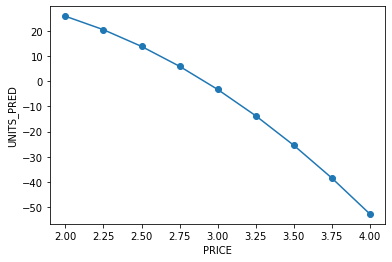

,PRICE,PRICE_p2,FEATURE,DISPLAY,TPR_ONLY,RELPRICE,UNITS_PRED
0,2.00,4.000,0.0,0.0,0.0,1.0,25.875
1,2.25,5.062,0.0,0.0,0.0,1.0,20.512
2,2.50,6.250,0.0,0.0,0.0,1.0,13.872
3,2.75,7.562,0.0,0.0,0.0,1.0,5.956
4,3.00,9.000,0.0,0.0,0.0,1.0,-3.237
5,3.25,10.562,0.0,0.0,0.0,1.0,-13.707
6,3.50,12.250,0.0,0.0,0.0,1.0,-25.454
7,3.75,14.062,0.0,0.0,0.0,1.0,-38.477
8,4.00,16.000,0.0,0.0,0.0,1.0,-52.777


In [12]:
# sélection d'un UPC
upc = productList[1]

# prix variables
prices = [2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]

# génération d'entrées pour le tracé en utilisant des prix variables (2 premières caractéristiques)
# et d'autres caractéristiques fixes 
# ['PRICE', 'PRICE_p2', 'FEATURE', 'DISPLAY', 'TPR_ONLY', 'RELPRICE']
input_x = np.array([[p, p**2, 0, 0, 0, 1.0] for p in prices])

# prédiction de la demande
predict_y = regr[upc].predict(input_x)
plt.plot(prices, predict_y, marker='o')
plt.xlabel('PRICE')
plt.ylabel('UNITS_PRED')
plt.show()

cols = feature_list + ['UNITS_PRED']
with pd.option_context('display.precision', 3):  # permet de changer l'affichage des décimales
    display(pd.DataFrame(np.append(input_x, predict_y.reshape(-1,1), axis=1), 
                         columns=cols))

## Arbre de régression
De même, nous obtenons les résultats de l'arbre de régression en changeant simplement le nom de la fonction.

In [13]:
regr = {}  # nous stockons les différents modèles dans un dictionnaire
regrSummary = pd.DataFrame(columns=['trainRMSE', 'testRMSE','testMAE','testMAPE'], index=productList)

for upc in productList:
    regr[upc] = DecisionTreeRegressor(random_state=0).fit(X_train[upc], y_train[upc])  # crée et entraîne le modèle
    y_pred_train = regr[upc].predict(X_train[upc])  # calcule les prédictions pour y_train
    trainRMSE = np.sqrt(mean_squared_error(y_train[upc], y_pred_train))  # calule le RMSE en faisant la racine de MSE

    y_pred[upc] = regr[upc].predict(X_test[upc])

    testRMSE = np.sqrt(mean_squared_error(y_test[upc], y_pred[upc]))
    testMAE = mean_absolute_error(y_test[upc], y_pred[upc])
    testMAPE = np.mean(np.abs((y_test[upc] - y_pred[upc]) / y_test[upc]))
    regrSummary.loc[upc] = [trainRMSE, testRMSE, testMAE, testMAPE]  # met les résultats sur la ligne upc

print('**Arbre de régression**')
with pd.option_context('display.precision', 3):  # permet de changer l'affichage des décimales
    display(regrSummary.round(2))
print(f"Moyenne des RMSE d'entraînement: {regrSummary['trainRMSE'].mean():.2f}")
print(f"Moyenne des RMSE d'évaluation: {regrSummary['testRMSE'].mean():.2f}")
print(f"Moyenne des MAE d'évaluation: {regrSummary['testMAE'].mean():.2f}")
print(f"Moyenne des MAPE d'évaluation: {regrSummary['testMAPE'].mean():.2f}")

**Arbre de régression**


,trainRMSE,testRMSE,testMAE,testMAPE
1111085319,2.038,10.76,7.103,0.841
1111085350,0.0,7.471,5.923,0.626
1600027527,1.147,30.33,15.564,0.52
1600027528,2.656,13.221,8.641,0.287
1600027564,0.0,10.454,7.897,0.389
3000006340,0.514,7.762,4.5,0.993
3800031829,1.544,9.132,7.487,0.421


Moyenne des RMSE d'entraînement: 1.13
Moyenne des RMSE d'évaluation: 12.73
Moyenne des MAE d'évaluation: 8.16
Moyenne des MAPE d'évaluation: 0.58


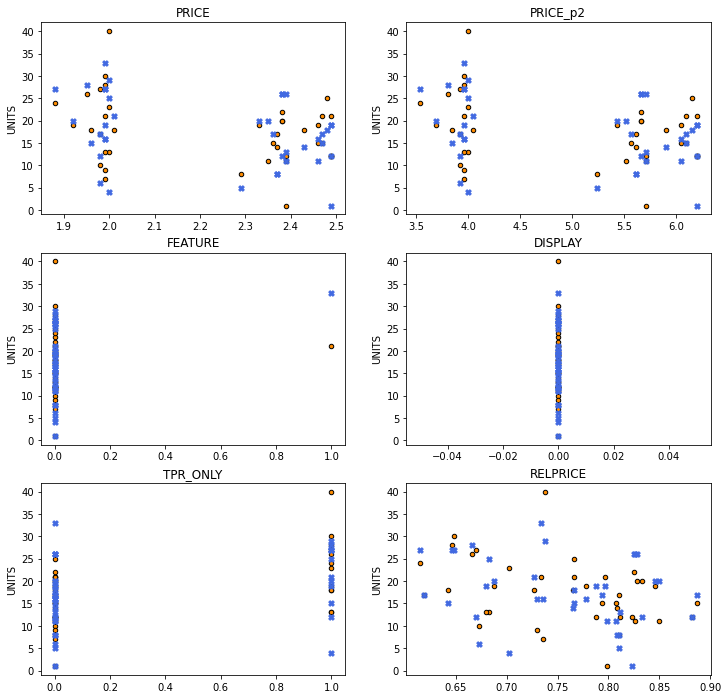

In [14]:
# Montrer les résultats de prédiction pour un produit (UPC)
upc = productList[1]  # sélection d'un UPC
plot_data_scatter(X_test[upc], y_test[upc], X_test[upc], y_pred[upc], feature_list)

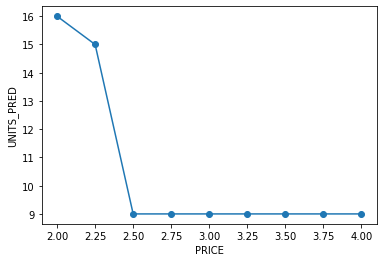

,PRICE,PRICE_p2,FEATURE,DISPLAY,TPR_ONLY,RELPRICE,UNITS_PRED
0,2.00,4.000,0.0,0.0,0.0,1.0,16.0
1,2.25,5.062,0.0,0.0,0.0,1.0,15.0
2,2.50,6.250,0.0,0.0,0.0,1.0,9.0
3,2.75,7.562,0.0,0.0,0.0,1.0,9.0
4,3.00,9.000,0.0,0.0,0.0,1.0,9.0
5,3.25,10.562,0.0,0.0,0.0,1.0,9.0
6,3.50,12.250,0.0,0.0,0.0,1.0,9.0
7,3.75,14.062,0.0,0.0,0.0,1.0,9.0
8,4.00,16.000,0.0,0.0,0.0,1.0,9.0


In [15]:
# sélection d'un UPC
upc = productList[1]

# prix variables
prices = [2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]

# génération d'entrées pour le tracé en utilisant des prix variables (2 premières caractéristiques)
# et d'autres caractéristiques fixes 
# ['PRICE', 'PRICE_p2', 'FEATURE', 'DISPLAY', 'TPR_ONLY', 'RELPRICE']
input_x = np.array([[p, p**2, 0, 0, 0, 1.0] for p in prices])

# prédiction de la demande
predict_y = regr[upc].predict(input_x)
plt.plot(prices, predict_y, marker='o')
plt.xlabel('PRICE')
plt.ylabel('UNITS_PRED')
plt.show()

cols = feature_list + ['UNITS_PRED']
with pd.option_context('display.precision', 3):  # permet de changer l'affichage des décimales
    display(pd.DataFrame(np.append(input_x, predict_y.reshape(-1,1), axis=1), 
                         columns=cols))

## Forêt aléatoire

In [16]:
regr = {}  # nous stockons les différents modèles dans un dictionnaire
regrSummary = pd.DataFrame(columns=['trainRMSE', 'testRMSE','testMAE','testMAPE'], index=productList)

for upc in productList:
    regr[upc] = RandomForestRegressor(random_state=0).fit(X_train[upc], y_train[upc])  # crée et entraîne le modèle
    y_pred_train = regr[upc].predict(X_train[upc])  # calcule les prédictions pour y_train
    trainRMSE = np.sqrt(mean_squared_error(y_train[upc], y_pred_train))  # calule le RMSE en faisant la racine de MSE

    y_pred[upc] = regr[upc].predict(X_test[upc])

    testRMSE = np.sqrt(mean_squared_error(y_test[upc], y_pred[upc]))
    testMAE = mean_absolute_error(y_test[upc], y_pred[upc])
    testMAPE = np.mean(np.abs((y_test[upc] - y_pred[upc]) / y_test[upc]))
    regrSummary.loc[upc] = [trainRMSE, testRMSE, testMAE, testMAPE]  # met les résultats sur la ligne upc

print('**Forêt aléatoire**')
with pd.option_context('display.precision', 3):  # permet de changer l'affichage des décimales
    display(regrSummary.round(2))
print(f"Moyenne des RMSE d'entraînement: {regrSummary['trainRMSE'].mean():.2f}")
print(f"Moyenne des RMSE d'évaluation: {regrSummary['testRMSE'].mean():.2f}")
print(f"Moyenne des MAE d'évaluation: {regrSummary['testMAE'].mean():.2f}")
print(f"Moyenne des MAPE d'évaluation: {regrSummary['testMAPE'].mean():.2f}")

**Forêt aléatoire**


,trainRMSE,testRMSE,testMAE,testMAPE
1111085319,3.579,8.293,6.241,0.835
1111085350,3.203,7.437,5.807,0.658
1600027527,6.196,23.598,11.882,0.426
1600027528,4.92,14.529,8.703,0.276
1600027564,4.135,7.699,5.91,0.32
3000006340,2.065,4.77,3.092,0.83
3800031829,3.696,8.724,6.724,0.391


Moyenne des RMSE d'entraînement: 3.97
Moyenne des RMSE d'évaluation: 10.72
Moyenne des MAE d'évaluation: 6.91
Moyenne des MAPE d'évaluation: 0.53


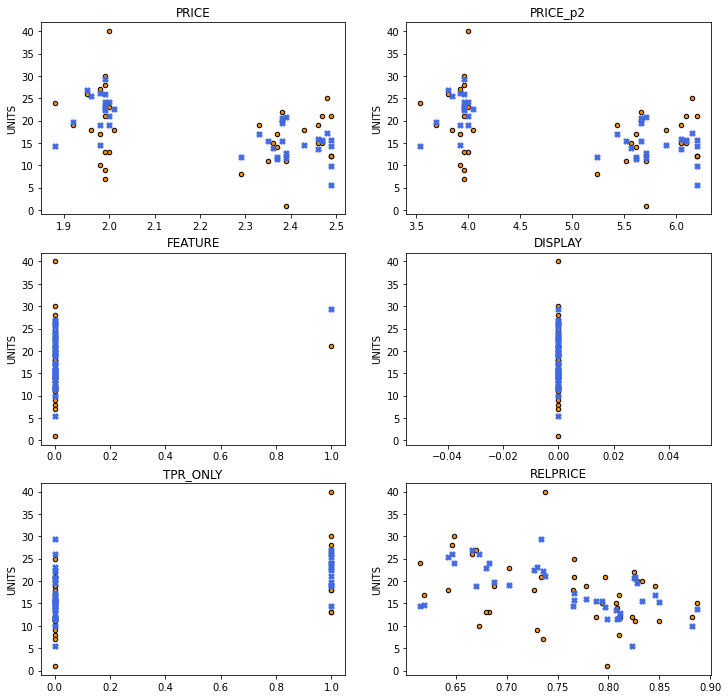

In [17]:
# Montrer les résultats de prédiction pour un produit (UPC)
upc = productList[1]  # sélection d'un UPC
plot_data_scatter(X_test[upc], y_test[upc], X_test[upc], y_pred[upc], feature_list)

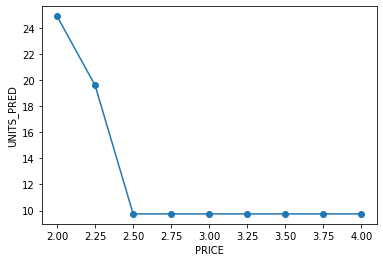

,PRICE,PRICE_p2,FEATURE,DISPLAY,TPR_ONLY,RELPRICE,UNITS_PRED
0,2.00,4.000,0.0,0.0,0.0,1.0,24.91
1,2.25,5.062,0.0,0.0,0.0,1.0,19.60
2,2.50,6.250,0.0,0.0,0.0,1.0,9.74
3,2.75,7.562,0.0,0.0,0.0,1.0,9.74
4,3.00,9.000,0.0,0.0,0.0,1.0,9.74
5,3.25,10.562,0.0,0.0,0.0,1.0,9.74
6,3.50,12.250,0.0,0.0,0.0,1.0,9.74
7,3.75,14.062,0.0,0.0,0.0,1.0,9.74
8,4.00,16.000,0.0,0.0,0.0,1.0,9.74


In [18]:
# sélection d'un UPC
upc = productList[1]

# prix variables
prices = [2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]

# génération d'entrées pour le tracé en utilisant des prix variables (2 premières caractéristiques)
# et d'autres caractéristiques fixes 
# ['PRICE', 'PRICE_p2', 'FEATURE', 'DISPLAY', 'TPR_ONLY', 'RELPRICE']
input_x = np.array([[p, p**2, 0, 0, 0, 1.0] for p in prices])

# prédiction de la demande
predict_y = regr[upc].predict(input_x)
plt.plot(prices, predict_y, marker='o')
plt.xlabel('PRICE')
plt.ylabel('UNITS_PRED')
plt.show()

cols = feature_list + ['UNITS_PRED']
with pd.option_context('display.precision', 3):  # permet de changer l'affichage des décimales
    display(pd.DataFrame(np.append(input_x, predict_y.reshape(-1,1), axis=1), 
                         columns=cols))

# Bloc 4: sélection du modèle
En comparant les résultats moyens, nous pouvons remarquer que dans ce cas-ci la régression linéaire est légèrement mieux que l'arbre de régression et équivalente à la forêt aléatoire. De plus, la fonction prédite avec la régression linéaire a une plus belle représentation puisque les changements sont monotones (voir le graphique demande-prix). Par conséquent, nous utiliserons le modèle de régression linéaire sur l'ensemble des données en remplaçant `X_train` par `X`. Étant donné que le modèle utilisera davantage de données, ses erreurs de prévision devraient généralement diminuer sur des nouvelles observations. Ce modèle sera utilisé pour les nouvelles données dans les modèles d'optimisation lors de la prochaine séance.

In [19]:
regr = {}  # nous stockons les différents modèles dans un dictionnaire
regrSummary = pd.DataFrame(columns=['totalRMSE', 'totalMAE','totalMAPE'], index=productList)

for upc in productList:
    regr[upc] = LinearRegression().fit(X[upc], y[upc])
    y_pred[upc] = regr[upc].predict(X[upc])
    totalRMSE = np.sqrt(mean_squared_error(y[upc], y_pred[upc]))
    totalMAE = mean_absolute_error(y[upc], y_pred[upc])
    totalMAPE = np.mean(np.abs((y[upc] - y_pred[upc]) / y[upc]))
    regrSummary.loc[upc] = [totalRMSE, totalMAE, totalMAPE]

print('**Régression linéaire (avec toutes les données)**')
with pd.option_context('display.precision', 3):  # permet de changer l'affichage des décimales
    display(regrSummary.round(2))
print(f"Moyenne des RMSE: {regrSummary['totalRMSE'].mean():.2f}")
print(f"Moyenne des MAE: {regrSummary['totalMAE'].mean():.2f}")
print(f"Moyenne des MAPE: {regrSummary['totalMAPE'].mean():.2f}")

**Régression linéaire (avec toutes les données)**


,totalRMSE,totalMAE,totalMAPE
1111085319,7.757,6.082,0.643
1111085350,7.312,5.804,0.64
1600027527,16.926,9.773,0.611
1600027528,10.426,7.059,0.303
1600027564,8.303,5.99,0.297
3000006340,4.12,2.865,0.7
3800031829,7.81,6.164,0.336


Moyenne des RMSE: 8.95
Moyenne des MAE: 6.25
Moyenne des MAPE: 0.50


Prendre note qu'il aurait aussi été intéressant de faire de la validation croisée et une recherche d'hyper-paramètres afin de déterminer le meilleur modèle prédictif (p.ex., avec `GridSearchCV` vu précédemment). Toutefois, ceci aurait nécessité davantage de temps de calcul.